<a href="https://colab.research.google.com/github/gauravjain14/All-about-JAX/blob/main/jax101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello JAX

This notebook follows the JAX 101 tutorial and covers the basics in a succint manner

## Section 1: Getting started with JAX numpy

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


This looks very much like and under the hood, it is. However, here the type of the array is where all the JEDI tricks happen. One of the most useful features of JAX (**I don't think JAX is the only one though**) is same code can be run on different backends.

In [ ]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

**Bonus**: When a code block is executed on JAX, it is deployed on the accelerator JAX is configured to use. For instance, if the TPU is available, JAX can launch the kernel, asynchronously, on the TPU and the subsequent Python statements can continue to execute and not be blocked

In [ ]:
from jax._src.api import block_until_ready
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

The slowest run took 5.81 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 6.79 ms per loop


## Section 2: **grad** - JAX first selling point

A fundamental feature of JAX is to allow transformation of functions. Let's understand what it means, in practice

In [ ]:
def sum_of_squares(x):
  return jnp.sum(x**2)

Applying **grad** to the `sum_of_squares` function will return the gradient of `sum_of_squares` w.r.t x.

Once we have this function, we can use it to return the derivates w.r.t each element of the array.

Analogously, `jax.grad(f)` is the function that computes the gradient, so jax.`grad(f)(x)` is the gradient of f at `x`.

In [ ]:
# Demo grad
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

# square all the elements in x
print(sum_of_squares(x))

# get gradient of x**2 w.r.t x
print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


### Extending this further, we can take derivates w.r.t multiple variables

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [ ]:
# If no arguments are provided for the derivative function, the gradient is
# calculated w.r.t the first argument of the function.

jax.grad(sum_squared_error, argnums=(0, 1))(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [ ]:
# In most cases, we require both the value and the derivative and we can do that
# as follows

jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

# Different from Numpy. How?

Let's briefly echo what the JAX developers say are the important differences between JAX and Numpy.

JAX is designed to be functional, as in *functional programming*. For now, it's more than enough to understand that functions in JAX shouldn't have any **side effects**. Let's see what this means.

In [ ]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123  # We are changing the value of x
  return None

in_place_modify(x)
x

array([123,   2,   3])

Let's see what happens when we try to pass a JAX array to this function

In [ ]:
in_place_modify(jnp.array(x))

TypeError: ignored

### How do we then modify the value of x in JAX, then?

In [ ]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])

# We see that y remains unchanged and the function returns a new array
# Such functions are generally called functionally pure
print(jax_in_place_modify(y))
print(y)

[123   2   3]
[1 2 3]


# First JAX training loop

Let's take a leap of faith here and see how to **build a simple training loop.**

We'll be training the following function -

$$y = w_{true}x + b_{true} + \epsilon$$

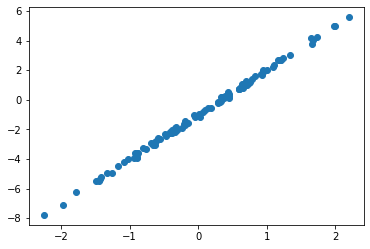

In [ ]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))

noise = np.random.normal(scale=0.1, size=(100,))

ys = xs * 3 -1  + noise

plt.scatter(xs, ys)

In [ ]:
# We will use a single array, theta = [w, b] to house both parameters

def model(theta, x):
  """ Computes wx + b on a batch of input x. """
  w,b = theta
  return w * x + b

In [ ]:
# Let's look at the loss function
# J(x,y; theta) = (y' - y)**2

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction - y) ** 2)

## Probably not for the uninitiated.
# The following function is required to optimize the loss function
# For a quick recap, at each step of the training loop, we find the
# gradient of the loss w.r.t the parameters and take a small step
# in the direction of steepest descent
#
# Note: This is just a demo and we are not really optimizing for training
# For more details 
# https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html#your-first-jax-training-loop
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.02, b: -1.00


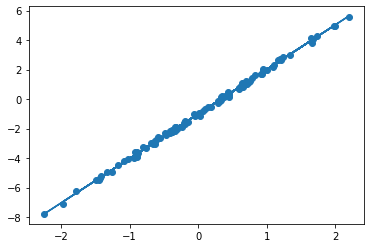

In [ ]:
# The training loop

theta = jnp.array([1., 1.])

# Taking 1000 steps for training
for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")